# Sentence Embedding
Riordan Callil 2021
Honours research
Developing an instruction understanding robot
Current design: Instruction understanding using sentence embedding. Sentence embedding network will be trained in two phases. (1) Trained as a sentence autoencoder. Using the translation encoder-decoder framework. I will train the network to reconstruct the initial instruction from the latent representation. (2) I will fine tune the networks latent representations by training a classifier that uses the latent space to predict instruction action. (3) (FUTURE) As an additional step I might train the sentence autoencoder to translate high level instructions to low level instructions and visa versa. 

# Utils

In [2]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.show()

# Dataset: ALFRED

In [49]:
import tqdm
import glob
import json
import string
import torchtext
from torchtext.data import get_tokenizer
from nltk.stem import WordNetLemmatizer

# Loading and Transforming the ALFRED dataset utilites

def load_next_alfred_data(ALFRED_JSON_PATTERN):
    """
     Get list of all instructions and their trajectories
     glob.glob gets all files and stores them. iglob makes an iterator.
     
    Paramaters:
        @alfred_json_pattern
        A string which represents the location of the data with glob style
        regex expressions to denote multiple subdirectories.
    """ 
    train_json_files = glob.glob(ALFRED_JSON_PATTERN)
    tokenizer = get_tokenizer("basic_english")
    wnl = WordNetLemmatizer()
    dataset = []
    
    def preprocess_sentence(sentence):
        sentence = tokenizer(sentence)
        sentence = filter(lambda x: not x in string.punctuation, sentence)
        sentence = [wnl.lemmatize(word) for word in sentence]
        return sentence
    
    # Yeild an alfred json
    for json_file_idx in tqdm.tqdm(range(len(train_json_files))):
        data = json.load(open(train_json_files[json_file_idx]))
        annotations = data['turk_annotations']['anns']
        actions = data['plan']['high_pddl']
        scene = data['scene']
        scene['task_id'] = data['task_id']
        
        instruction_actions = []
        for d in annotations:
            votes = d['votes']
            if any(votes): # WARNING: Limiting dataset based on votes
                trajectory = {'task_desc': [], 'instructions': []}
                trajectory['task_desc'] = preprocess_sentence(d['task_desc'])
                for i in range(len(d['high_descs'])):
                    sanitized_instruction = preprocess_sentence(d['high_descs'][i])
                    instruction = {'instruction': sanitized_instruction, 
                                   'action': actions[i]['discrete_action']['action'],
                                   'argument_1': actions[i]['discrete_action']['args'][0] if 0 < len(actions[i]['discrete_action']['args']) else '<unk>', 
                                   'argument_2': actions[i]['discrete_action']['args'][1] if 1 < len(actions[i]['discrete_action']['args']) else '<unk>'}
                    trajectory['instructions'].append(instruction)
                instruction_actions.append(trajectory)

        if len(instruction_actions) > 0:
            dataset.append((instruction_actions, scene))
    return dataset

train_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/train/*/*/*.json")
eval_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json")

100%|███████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 80.42it/s]


In [50]:
import json
import os

class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
    
    def add_sentence(self, sentence):
        for word in sentence:
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index: # Add word to langauge if unseen 
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word(self, index):
        return self.index2word.get(str(index))
    
    def index(self, word):
        return self.word2index.get(word)
    
    def dump(self, filename):
        obj = {
            'word2index' : self.word2index,
            'word2count' : self.word2count,
            'index2word' : self.index2word,
            'n_words' : self.n_words
        }
        with open(filename, 'w') as fp:
            json.dump(obj, fp)
    
    def load(self, filename):
        with open(filename, 'r') as fp:
            obj = json.load(fp)
            self.word2index = obj['word2index']
            self.word2count = obj['word2count']
            self.index2word = obj['index2word']
            self.n_words = obj['n_words']
    
    def reset_counts(self):
        self.word2count = dict.fromkeys(self.word2count, 0)

# Check if backup, pickled, langauge object exists
lang = Language()
if os.path.isfile('instruction_language.json'):
    lang.load('instruction_language.json')
    lang.reset_counts()

action_lang = Language()
if os.path.isfile('action_language.json'):
    action_lang.load('action_language.json')
    action_lang.reset_counts()

argument_lang = Language()
if os.path.isfile('argument_language.json'):
    argument_lang.load('argument_language.json')
    argument_lang.reset_counts()

lang.add_sentence(["<SOS>", "<EOS>"])
action_lang.add_sentence(["<SOS>", "<EOS>"])
argument_lang.add_sentence(["<SOS>", "<EOS>"])

def add_dataset_to_language(lang, dataset):
    sentence_lengths = []
    # Add dataset to langauge object
    for task in tqdm.tqdm(dataset): 
        for trajectory in task[0]:
            lang.add_sentence(trajectory['task_desc'])
            sentence_lengths.append(len(trajectory['task_desc']))
            for instruction in trajectory['instructions']:
                instruction_text = instruction['instruction']
                instruction_action = instruction['action']
                instruction_arg_1 = instruction['argument_1']
                instruction_arg_2 = instruction['argument_2']
                if len(instruction_text) > 0:
                    lang.add_sentence(instruction_text)
                action_lang.add_word(instruction_action)
                if instruction_arg_1 != '<unk>':
                    lang.add_word(instruction_arg_1)
                    argument_lang.add_word(instruction_arg_1)
                if instruction_arg_2 != '<unk>':
                    lang.add_word(instruction_arg_2)
                    argument_lang.add_word(instruction_arg_2)
                
            sentence_lengths.append(len(instruction_text))
    return sentence_lengths
                    
sentence_lengths = add_dataset_to_language(lang, train_dataset)
eval_sentence_lengths = add_dataset_to_language(lang, eval_dataset)
sentence_lengths.extend(eval_sentence_lengths)

print('average sentence length = %.2f words' % (sum(sentence_lengths) / len(sentence_lengths)))
print('max eval sentence length = %d words' % (max(eval_sentence_lengths)))

# Pickle the language as a backup
lang.dump('instruction_language.json')
action_lang.dump('action_language.json')
argument_lang.dump('argument_language.json')

print('vocab size =', lang.n_words)
print('most common words: ', sorted(lang.word2count.items(), key=lambda item: item[1], reverse=True)[:10])
print('most common actions: ', sorted(action_lang.word2count.items(), key=lambda item: item[1], reverse=True))
print('number of arguments = ', argument_lang.n_words)

print(action_lang.word2index)
print(argument_lang.word2index)

100%|█████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 9106.95it/s]

average sentence length = 9.79 words
max eval sentence length = 32 words
vocab size = 2053
most common words:  [('the', 349610), ('to', 98305), ('turn', 72887), ('and', 66582), ('on', 56709), ('of', 55891), ('right', 44577), ('left', 43432), ('in', 38055), ('a', 34381)]
most common actions:  [('GotoLocation', 70355), ('PickupObject', 31968), ('PutObject', 29426), ('SliceObject', 3152), ('HeatObject', 3079), ('CoolObject', 3059), ('CleanObject', 2955), ('ToggleObject', 2424), ('<SOS>', 1), ('<EOS>', 1)]
number of arguments =  83
{'<SOS>': 0, '<EOS>': 1, 'GotoLocation': 2, 'PickupObject': 3, 'ToggleObject': 4, 'PutObject': 5, 'SliceObject': 6, 'CleanObject': 7, 'CoolObject': 8, 'HeatObject': 9}
{'<SOS>': 0, '<EOS>': 1, 'dresser': 2, 'alarmclock': 3, 'desklamp': 4, 'desk': 5, 'shelf': 6, 'sidetable': 7, 'baseballbat': 8, 'basketball': 9, 'book': 10, 'bed': 11, 'bowl': 12, 'sofa': 13, 'box': 14, 'coffeetable': 15, 'diningtable': 16, 'floorlamp': 17, 'candle': 18, 'cd': 19, 'drawer': 20, 'g

In [51]:
###### Train Cirriculum ######
train_reconstruction = [] # [any text, any text]
train_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
train_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(train_dataset):
    for trajectory in task[0]:
        train_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                train_reconstruction.append(instruction_text)
                train_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                train_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('train reconstruction samples =', len(train_reconstruction))
print('train high -> low pairs =', len(train_high_low_pairs))
print('train low -> action / argument pairs =', len(train_low_action_argument_pairs))

###### Eval Cirriculum ######
eval_reconstruction = [] # [any text, any text]
eval_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
eval_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(eval_dataset):
    for trajectory in task[0]:
        eval_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                eval_reconstruction.append(instruction_text)
                eval_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                eval_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('eval reconstruction samples =', len(eval_reconstruction))
print('eval high -> low pairs =', len(eval_high_low_pairs))
print('eval low -> action / argument pairs =', len(eval_low_action_argument_pairs))

import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

# Prepare data for tensor representation
def indices_from_sentence(lang, sentence):
    return [lang.index(word) for word in sentence]

def tensor_from_sentence(lang, sentence):
    indices = indices_from_sentence(lang, sentence)
    indices.append(lang.index('<EOS>'))
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1,1)

def tensors_from_pair(input_lang, output_lang, pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

rpair = random.choice(train_low_action_argument_pairs)
print(rpair)
print(tensors_from_pair(lang, action_lang, [rpair[0], rpair[1]]))

100%|████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 25500.02it/s]


train reconstruction samples = 162303
train high -> low pairs = 141278
train low -> action / argument pairs = 141278
eval reconstruction samples = 5961
eval high -> low pairs = 5140
eval low -> action / argument pairs = 5140
using device: cuda
[['pick', 'up', 'the', 'plate', 'with', 'the', 'spatula', 'on', 'it'], ['PickupObject'], ['plate']]
(tensor([[  2],
        [  3],
        [  4],
        [314],
        [ 38],
        [  4],
        [919],
        [  9],
        [122],
        [  1]], device='cuda:0'), tensor([[3],
        [1]], device='cuda:0'))


# Model

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

MAX_LENGTH = 10

# Sourced from Pytorch Tutorial: Seq2Seq Translation Tutorial
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class ActionPredictor(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(ActionPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        
        self.linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input):
        output = F.relu(self.linear1(input))
        output = self.dropout(output)
        output = F.log_softmax(self.linear2(output), dim=0)
        return output

# Train - Action Predictor

updates:  63313
0m 0s (- 6m 51s) (100 0%) 0.0971
0m 1s (- 6m 38s) (200 0%) 0.0152
0m 1s (- 6m 28s) (300 0%) 0.0119
0m 2s (- 6m 26s) (400 0%) 0.2056
0m 3s (- 6m 23s) (500 0%) 0.1077
0m 3s (- 6m 20s) (600 0%) 0.0093
0m 4s (- 6m 16s) (700 1%) 0.2564
0m 4s (- 6m 16s) (800 1%) 0.0113
0m 5s (- 6m 15s) (900 1%) 0.0108
0m 5s (- 6m 13s) (1000 1%) 0.0388
0m 6s (- 6m 12s) (1100 1%) 0.0034
0m 7s (- 6m 12s) (1200 1%) 0.0810
0m 7s (- 6m 12s) (1300 2%) 0.0809
0m 8s (- 6m 11s) (1400 2%) 0.0074
0m 9s (- 6m 11s) (1500 2%) 0.0363
0m 9s (- 6m 10s) (1600 2%) 0.0120
0m 10s (- 6m 8s) (1700 2%) 0.0078
0m 10s (- 6m 7s) (1800 2%) 0.0529
0m 11s (- 6m 6s) (1900 3%) 0.0091
0m 11s (- 6m 4s) (2000 3%) 0.0942
0m 12s (- 6m 2s) (2100 3%) 0.0069
0m 13s (- 6m 2s) (2200 3%) 0.1120
0m 13s (- 6m 1s) (2300 3%) 0.0046
0m 14s (- 6m 0s) (2400 3%) 0.0051
0m 14s (- 5m 59s) (2500 3%) 0.0045
0m 15s (- 5m 58s) (2600 4%) 0.0064
0m 15s (- 5m 58s) (2700 4%) 0.0016
0m 16s (- 5m 57s) (2800 4%) 0.0072
0m 17s (- 5m 56s) (2900 4%) 0.0018
0m

2m 24s (- 4m 14s) (22900 36%) 0.0051
2m 25s (- 4m 14s) (23000 36%) 0.1204
2m 25s (- 4m 13s) (23100 36%) 0.1211
2m 26s (- 4m 12s) (23200 36%) 0.0639
2m 26s (- 4m 12s) (23300 36%) 0.0087
2m 27s (- 4m 11s) (23400 36%) 0.0158
2m 28s (- 4m 11s) (23500 37%) 0.0106
2m 28s (- 4m 10s) (23600 37%) 0.0095
2m 29s (- 4m 9s) (23700 37%) 0.0334
2m 30s (- 4m 9s) (23800 37%) 0.0829
2m 30s (- 4m 8s) (23900 37%) 0.0045
2m 31s (- 4m 7s) (24000 37%) 0.2050
2m 31s (- 4m 7s) (24100 38%) 0.0206
2m 32s (- 4m 6s) (24200 38%) 0.0207
2m 33s (- 4m 6s) (24300 38%) 0.0511
2m 33s (- 4m 5s) (24400 38%) 0.0172
2m 34s (- 4m 4s) (24500 38%) 0.0734
2m 35s (- 4m 4s) (24600 38%) 0.0692
2m 35s (- 4m 3s) (24700 39%) 0.0036
2m 36s (- 4m 2s) (24800 39%) 0.0119
2m 37s (- 4m 2s) (24900 39%) 0.0035
2m 37s (- 4m 1s) (25000 39%) 0.0040
2m 38s (- 4m 1s) (25100 39%) 0.0059
2m 38s (- 4m 0s) (25200 39%) 0.0509
2m 39s (- 3m 59s) (25300 39%) 0.1344
2m 40s (- 3m 59s) (25400 40%) 0.1466
2m 40s (- 3m 58s) (25500 40%) 0.0366
2m 41s (- 3m 57s)

4m 44s (- 1m 53s) (45300 71%) 0.0065
4m 45s (- 1m 52s) (45400 71%) 0.1706
4m 45s (- 1m 51s) (45500 71%) 0.0049
4m 46s (- 1m 51s) (45600 72%) 0.0021
4m 47s (- 1m 50s) (45700 72%) 0.0281
4m 47s (- 1m 50s) (45800 72%) 0.0037
4m 48s (- 1m 49s) (45900 72%) 0.0015
4m 49s (- 1m 48s) (46000 72%) 0.0438
4m 49s (- 1m 48s) (46100 72%) 0.0021
4m 50s (- 1m 47s) (46200 72%) 0.0104
4m 51s (- 1m 46s) (46300 73%) 0.0026
4m 51s (- 1m 46s) (46400 73%) 0.0563
4m 52s (- 1m 45s) (46500 73%) 0.0023
4m 52s (- 1m 45s) (46600 73%) 0.0637
4m 53s (- 1m 44s) (46700 73%) 0.0040
4m 54s (- 1m 43s) (46800 73%) 0.0020
4m 54s (- 1m 43s) (46900 74%) 0.0106
4m 55s (- 1m 42s) (47000 74%) 0.0024
4m 56s (- 1m 41s) (47100 74%) 0.0014
4m 56s (- 1m 41s) (47200 74%) 0.0466
4m 57s (- 1m 40s) (47300 74%) 0.0047
4m 57s (- 1m 40s) (47400 74%) 0.0089
4m 58s (- 1m 39s) (47500 75%) 0.0086
4m 59s (- 1m 38s) (47600 75%) 0.0040
4m 59s (- 1m 38s) (47700 75%) 0.7082
5m 0s (- 1m 37s) (47800 75%) 0.0239
5m 1s (- 1m 36s) (47900 75%) 0.0156
5m 

<Figure size 432x288 with 0 Axes>

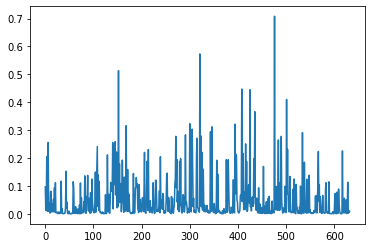

In [58]:
def train(input_tensor, target_action, encoder, predictor, encoder_optimizer, predictor_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    predictor_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # Without teacher forcing: use its own predictions as the next input
    predictor_output = predictor(encoder_hidden.flatten())
    topv, topi = predictor_output.topk(1)
    #predictor_output = topi.squeeze().detach()  # detach from history as input
    loss = criterion(predictor_output.unsqueeze(dim=0), target_action)

    loss.backward()
    
    encoder_optimizer.step()
    predictor_optimizer.step()

    return loss.item()

hidden_size = 256
learning_rate = 0.01
epochs = 1
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt'))

start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(action_predictor.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[1]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(action_lang, training_pair[1])[0]

        loss = train(input_tensor, target_tensor, encoder,
                     action_predictor, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(action_predictor.state_dict(), 'action_predictor.pt')

show_plot(plot_losses)

# Train - Argument Decoder

updates:  189939
0m 1s (- 32m 35s) (100 0%) 0.2628
0m 2s (- 31m 52s) (200 0%) 0.1783
0m 2s (- 31m 28s) (300 0%) 0.1297
0m 4s (- 31m 45s) (400 0%) 0.1245
0m 5s (- 31m 51s) (500 0%) 0.1226
0m 6s (- 31m 43s) (600 0%) 0.0523
0m 7s (- 32m 1s) (700 0%) 0.2052
0m 8s (- 32m 25s) (800 0%) 0.1766
0m 9s (- 32m 57s) (900 0%) 0.1338
0m 10s (- 33m 12s) (1000 0%) 0.0904
0m 11s (- 33m 17s) (1100 0%) 0.1646
0m 12s (- 33m 24s) (1200 0%) 0.1293
0m 13s (- 33m 28s) (1300 0%) 0.2247
0m 14s (- 33m 28s) (1400 0%) 0.1938
0m 15s (- 33m 25s) (1500 0%) 0.2266
0m 16s (- 33m 17s) (1600 0%) 0.1699
0m 17s (- 33m 9s) (1700 0%) 0.0263
0m 18s (- 33m 4s) (1800 0%) 0.1097
0m 20s (- 33m 4s) (1900 1%) 0.0256
0m 21s (- 32m 59s) (2000 1%) 0.0462
0m 22s (- 32m 53s) (2100 1%) 0.1314
0m 23s (- 32m 48s) (2200 1%) 0.1249
0m 24s (- 32m 44s) (2300 1%) 0.1151
0m 25s (- 32m 42s) (2400 1%) 0.1714
0m 26s (- 32m 37s) (2500 1%) 0.2811
0m 27s (- 32m 35s) (2600 1%) 0.2122
0m 28s (- 32m 35s) (2700 1%) 0.1273
0m 29s (- 32m 36s) (2800 1%) 0.13

4m 14s (- 31m 21s) (22600 11%) 0.2200
4m 15s (- 31m 20s) (22700 11%) 0.2216
4m 16s (- 31m 19s) (22800 12%) 0.1248
4m 17s (- 31m 18s) (22900 12%) 0.0657
4m 18s (- 31m 17s) (23000 12%) 0.1805
4m 19s (- 31m 17s) (23100 12%) 0.0809
4m 21s (- 31m 16s) (23200 12%) 0.0829
4m 22s (- 31m 15s) (23300 12%) 0.1084
4m 23s (- 31m 14s) (23400 12%) 0.0587
4m 24s (- 31m 14s) (23500 12%) 0.1578
4m 25s (- 31m 13s) (23600 12%) 0.0285
4m 26s (- 31m 12s) (23700 12%) 0.2112
4m 28s (- 31m 11s) (23800 12%) 0.2457
4m 29s (- 31m 11s) (23900 12%) 0.1575
4m 30s (- 31m 9s) (24000 12%) 0.2444
4m 31s (- 31m 9s) (24100 12%) 0.0543
4m 32s (- 31m 8s) (24200 12%) 0.0546
4m 33s (- 31m 7s) (24300 12%) 0.1810
4m 35s (- 31m 6s) (24400 12%) 0.1480
4m 36s (- 31m 4s) (24500 12%) 0.2770
4m 37s (- 31m 3s) (24600 12%) 0.1722
4m 38s (- 31m 2s) (24700 13%) 0.1042
4m 39s (- 31m 1s) (24800 13%) 0.1411
4m 40s (- 31m 0s) (24900 13%) 0.1005
4m 41s (- 30m 59s) (25000 13%) 0.0578
4m 42s (- 30m 58s) (25100 13%) 0.1657
4m 44s (- 30m 57s) (25

8m 19s (- 27m 16s) (44400 23%) 0.2727
8m 20s (- 27m 14s) (44500 23%) 0.1501
8m 21s (- 27m 13s) (44600 23%) 0.0909
8m 22s (- 27m 12s) (44700 23%) 0.1567
8m 23s (- 27m 11s) (44800 23%) 0.0494
8m 24s (- 27m 10s) (44900 23%) 0.1031
8m 25s (- 27m 9s) (45000 23%) 0.0704
8m 26s (- 27m 8s) (45100 23%) 0.2142
8m 28s (- 27m 6s) (45200 23%) 0.1136
8m 29s (- 27m 5s) (45300 23%) 0.1086
8m 30s (- 27m 4s) (45400 23%) 0.1974
8m 31s (- 27m 3s) (45500 23%) 0.0345
8m 32s (- 27m 2s) (45600 24%) 0.0378
8m 33s (- 27m 1s) (45700 24%) 0.1176
8m 34s (- 27m 0s) (45800 24%) 0.1443
8m 36s (- 26m 59s) (45900 24%) 0.0463
8m 37s (- 26m 58s) (46000 24%) 0.1086
8m 38s (- 26m 57s) (46100 24%) 0.1531
8m 39s (- 26m 55s) (46200 24%) 0.1840
8m 40s (- 26m 54s) (46300 24%) 0.1170
8m 41s (- 26m 53s) (46400 24%) 0.1376
8m 42s (- 26m 52s) (46500 24%) 0.1548
8m 43s (- 26m 51s) (46600 24%) 0.1391
8m 44s (- 26m 50s) (46700 24%) 0.0282
8m 46s (- 26m 49s) (46800 24%) 0.0825
8m 47s (- 26m 48s) (46900 24%) 0.0271
8m 48s (- 26m 46s) (4

12m 19s (- 23m 12s) (65900 34%) 0.2181
12m 20s (- 23m 11s) (66000 34%) 0.1308
12m 22s (- 23m 10s) (66100 34%) 0.1168
12m 23s (- 23m 8s) (66200 34%) 0.0399
12m 24s (- 23m 7s) (66300 34%) 0.0190
12m 25s (- 23m 6s) (66400 34%) 0.1489
12m 26s (- 23m 5s) (66500 35%) 0.0628
12m 27s (- 23m 3s) (66600 35%) 0.0285
12m 28s (- 23m 2s) (66700 35%) 0.0694
12m 29s (- 23m 1s) (66800 35%) 0.1075
12m 30s (- 23m 0s) (66900 35%) 0.0953
12m 31s (- 22m 59s) (67000 35%) 0.0803
12m 32s (- 22m 57s) (67100 35%) 0.1097
12m 33s (- 22m 56s) (67200 35%) 0.1681
12m 34s (- 22m 55s) (67300 35%) 0.1398
12m 35s (- 22m 53s) (67400 35%) 0.0981
12m 36s (- 22m 52s) (67500 35%) 0.1596
12m 37s (- 22m 51s) (67600 35%) 0.1112
12m 38s (- 22m 49s) (67700 35%) 0.5077
12m 39s (- 22m 48s) (67800 35%) 0.1304
12m 40s (- 22m 47s) (67900 35%) 0.0977
12m 41s (- 22m 46s) (68000 35%) 0.1768
12m 43s (- 22m 45s) (68100 35%) 0.1113
12m 44s (- 22m 43s) (68200 35%) 0.1185
12m 45s (- 22m 42s) (68300 35%) 0.2634
12m 46s (- 22m 41s) (68400 36%) 0

16m 16s (- 19m 13s) (87100 45%) 0.2104
16m 17s (- 19m 12s) (87200 45%) 0.1955
16m 19s (- 19m 11s) (87300 45%) 0.1220
16m 20s (- 19m 9s) (87400 46%) 0.1505
16m 21s (- 19m 8s) (87500 46%) 0.0504
16m 22s (- 19m 7s) (87600 46%) 0.1183
16m 23s (- 19m 6s) (87700 46%) 0.1855
16m 24s (- 19m 5s) (87800 46%) 0.2350
16m 25s (- 19m 4s) (87900 46%) 0.1977
16m 26s (- 19m 3s) (88000 46%) 0.1106
16m 27s (- 19m 1s) (88100 46%) 0.1425
16m 28s (- 19m 0s) (88200 46%) 0.0749
16m 29s (- 18m 59s) (88300 46%) 0.0615
16m 31s (- 18m 58s) (88400 46%) 0.1030
16m 32s (- 18m 57s) (88500 46%) 0.2458
16m 33s (- 18m 56s) (88600 46%) 0.2150
16m 34s (- 18m 54s) (88700 46%) 0.1736
16m 35s (- 18m 53s) (88800 46%) 0.1000
16m 36s (- 18m 52s) (88900 46%) 0.1646
16m 37s (- 18m 51s) (89000 46%) 0.2290
16m 38s (- 18m 50s) (89100 46%) 0.1373
16m 40s (- 18m 49s) (89200 46%) 0.0876
16m 41s (- 18m 48s) (89300 47%) 0.0902
16m 42s (- 18m 47s) (89400 47%) 0.1610
16m 43s (- 18m 45s) (89500 47%) 0.0644
16m 44s (- 18m 44s) (89600 47%) 0.

20m 9s (- 15m 15s) (108100 56%) 0.0873
20m 10s (- 15m 14s) (108200 56%) 0.1028
20m 11s (- 15m 13s) (108300 57%) 0.0661
20m 12s (- 15m 12s) (108400 57%) 0.1929
20m 14s (- 15m 11s) (108500 57%) 0.0741
20m 15s (- 15m 10s) (108600 57%) 0.2020
20m 16s (- 15m 8s) (108700 57%) 0.1939
20m 17s (- 15m 7s) (108800 57%) 0.0463
20m 18s (- 15m 6s) (108900 57%) 0.0327
20m 19s (- 15m 5s) (109000 57%) 0.1121
20m 20s (- 15m 4s) (109100 57%) 0.1434
20m 21s (- 15m 3s) (109200 57%) 0.0507
20m 22s (- 15m 2s) (109300 57%) 0.0994
20m 24s (- 15m 1s) (109400 57%) 0.1244
20m 25s (- 15m 0s) (109500 57%) 0.1701
20m 26s (- 14m 58s) (109600 57%) 0.1350
20m 27s (- 14m 57s) (109700 57%) 0.1112
20m 28s (- 14m 56s) (109800 57%) 0.1927
20m 29s (- 14m 55s) (109900 57%) 0.1475
20m 30s (- 14m 54s) (110000 57%) 0.0454
20m 32s (- 14m 53s) (110100 57%) 0.1087
20m 33s (- 14m 52s) (110200 58%) 0.0306
20m 34s (- 14m 51s) (110300 58%) 0.1218
20m 35s (- 14m 50s) (110400 58%) 0.1039
20m 36s (- 14m 48s) (110500 58%) 0.1342
20m 37s (-

23m 59s (- 11m 23s) (128800 67%) 0.0783
24m 0s (- 11m 22s) (128900 67%) 0.1363
24m 1s (- 11m 21s) (129000 67%) 0.1370
24m 2s (- 11m 19s) (129100 67%) 0.2218
24m 3s (- 11m 18s) (129200 68%) 0.2139
24m 4s (- 11m 17s) (129300 68%) 0.1377
24m 5s (- 11m 16s) (129400 68%) 0.1228
24m 6s (- 11m 15s) (129500 68%) 0.0487
24m 7s (- 11m 14s) (129600 68%) 0.0253
24m 9s (- 11m 13s) (129700 68%) 0.1511
24m 10s (- 11m 11s) (129800 68%) 0.0727
24m 11s (- 11m 10s) (129900 68%) 0.0286
24m 12s (- 11m 9s) (130000 68%) 0.0703
24m 13s (- 11m 8s) (130100 68%) 0.1188
24m 14s (- 11m 7s) (130200 68%) 0.1158
24m 15s (- 11m 6s) (130300 68%) 0.0815
24m 16s (- 11m 4s) (130400 68%) 0.1177
24m 17s (- 11m 3s) (130500 68%) 0.1574
24m 18s (- 11m 2s) (130600 68%) 0.1478
24m 19s (- 11m 1s) (130700 68%) 0.1063
24m 20s (- 11m 0s) (130800 68%) 0.1538
24m 21s (- 10m 59s) (130900 68%) 0.0989
24m 22s (- 10m 58s) (131000 68%) 0.3532
24m 24s (- 10m 57s) (131100 69%) 0.2129
24m 25s (- 10m 56s) (131200 69%) 0.1049
24m 26s (- 10m 54s

27m 55s (- 7m 28s) (149800 78%) 0.0756
27m 56s (- 7m 27s) (149900 78%) 0.0915
27m 57s (- 7m 26s) (150000 78%) 0.0562
27m 58s (- 7m 25s) (150100 79%) 0.1624
27m 59s (- 7m 24s) (150200 79%) 0.0211
28m 0s (- 7m 23s) (150300 79%) 0.1467
28m 1s (- 7m 22s) (150400 79%) 0.2132
28m 3s (- 7m 21s) (150500 79%) 0.2017
28m 4s (- 7m 19s) (150600 79%) 0.1298
28m 5s (- 7m 18s) (150700 79%) 0.1621
28m 6s (- 7m 17s) (150800 79%) 0.0488
28m 7s (- 7m 16s) (150900 79%) 0.1055
28m 8s (- 7m 15s) (151000 79%) 0.1909
28m 9s (- 7m 14s) (151100 79%) 0.2069
28m 10s (- 7m 13s) (151200 79%) 0.2158
28m 11s (- 7m 12s) (151300 79%) 0.1147
28m 12s (- 7m 10s) (151400 79%) 0.1255
28m 13s (- 7m 9s) (151500 79%) 0.0716
28m 15s (- 7m 8s) (151600 79%) 0.0675
28m 16s (- 7m 7s) (151700 79%) 0.0881
28m 17s (- 7m 6s) (151800 79%) 0.2410
28m 18s (- 7m 5s) (151900 79%) 0.1712
28m 19s (- 7m 4s) (152000 80%) 0.2110
28m 20s (- 7m 3s) (152100 80%) 0.1116
28m 21s (- 7m 1s) (152200 80%) 0.1413
28m 22s (- 7m 0s) (152300 80%) 0.1885
28m 

31m 45s (- 3m 30s) (171000 90%) 0.2031
31m 46s (- 3m 29s) (171100 90%) 0.1080
31m 47s (- 3m 28s) (171200 90%) 0.1095
31m 48s (- 3m 27s) (171300 90%) 0.1429
31m 49s (- 3m 26s) (171400 90%) 0.0841
31m 50s (- 3m 25s) (171500 90%) 0.0999
31m 51s (- 3m 24s) (171600 90%) 0.0637
31m 52s (- 3m 23s) (171700 90%) 0.1675
31m 53s (- 3m 22s) (171800 90%) 0.1103
31m 54s (- 3m 20s) (171900 90%) 0.1906
31m 55s (- 3m 19s) (172000 90%) 0.1999
31m 56s (- 3m 18s) (172100 90%) 0.0553
31m 58s (- 3m 17s) (172200 90%) 0.0486
31m 59s (- 3m 16s) (172300 90%) 0.1236
32m 0s (- 3m 15s) (172400 90%) 0.1771
32m 1s (- 3m 14s) (172500 90%) 0.0485
32m 2s (- 3m 13s) (172600 90%) 0.0561
32m 3s (- 3m 12s) (172700 90%) 0.1428
32m 4s (- 3m 10s) (172800 90%) 0.1271
32m 5s (- 3m 9s) (172900 91%) 0.1725
32m 6s (- 3m 8s) (173000 91%) 0.0843
32m 7s (- 3m 7s) (173100 91%) 0.1964
32m 8s (- 3m 6s) (173200 91%) 0.1657
32m 10s (- 3m 5s) (173300 91%) 0.0320
32m 11s (- 3m 4s) (173400 91%) 0.0777
32m 12s (- 3m 3s) (173500 91%) 0.0524
32

<Figure size 432x288 with 0 Axes>

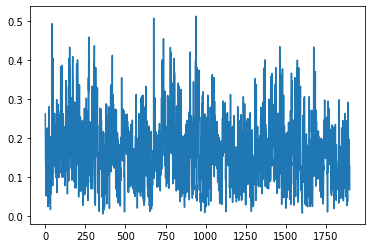

In [71]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[lang.index('<SOS>')]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == lang.index('<EOS>'):
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

hidden_size = 256
learning_rate = 0.01
epochs = 3
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))


start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(argument_decoder.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[2]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(argument_lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     argument_decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(argument_decoder.state_dict(), 'argument_decoder.pt')

show_plot(plot_losses)

# Action Predictor Eval

In [59]:
def evaluate(encoder, predictor, sentence, encoder_lang, action_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        predictor_output = predictor(encoder_hidden.flatten())
        topv, topi = predictor_output.topk(1)
        predicted_action = action_lang.word(topi.item())
        return predicted_action

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt'))

eval_pairs = [[sample[0], sample[1]] for sample in eval_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in eval_pairs:
    output = evaluate(encoder, action_predictor, sample[0], lang, action_lang)
    print(f"{' '.join(sample[0])} ({sample[1][0]}) -> {output} ({output == sample[1][0]})")
    results.append(output == sample[1][0])

samples: 2245
turn to the left and face the desk (GotoLocation) -> GotoLocation (True)
pick up the clock that is on the desk (PickupObject) -> PickupObject (True)
turn around and face the desk (GotoLocation) -> GotoLocation (True)
grab the canteen off of the desk (PickupObject) -> PickupObject (True)
turn right and find the desk with the lamp (GotoLocation) -> GotoLocation (True)
turn the lamp on (ToggleObject) -> ToggleObject (True)
turn left then face the desk (GotoLocation) -> GotoLocation (True)
pick up the alarm clock on the desk (PickupObject) -> PickupObject (True)
turn on the lamp (ToggleObject) -> ToggleObject (True)
pick up the clock on the desk top (PickupObject) -> PickupObject (True)
turn on the lamp (ToggleObject) -> ToggleObject (True)
walk to face right side of desk (GotoLocation) -> GotoLocation (True)
pick up red and grey bottle from desk (PickupObject) -> PickupObject (True)
walk to desk on right side of room (GotoLocation) -> GotoLocation (True)
turn on lamp on the 

pick up a phone from the couch (PickupObject) -> PickupObject (True)
move to the left of the couch (GotoLocation) -> GotoLocation (True)
turn on the lamp (ToggleObject) -> ToggleObject (True)
turn on the lamp (ToggleObject) -> ToggleObject (True)
turn on the light of the tall lamp (ToggleObject) -> PutObject (False)
turn on the lamp (ToggleObject) -> ToggleObject (True)
turn on the lamp (ToggleObject) -> ToggleObject (True)
walk to face couch (GotoLocation) -> GotoLocation (True)
pick up red credit card from couch (PickupObject) -> PickupObject (True)
walk left to face lamp (GotoLocation) -> GotoLocation (True)
turn on lamp near couch (ToggleObject) -> PutObject (False)
pick up the card on the couch (PickupObject) -> PickupObject (True)
cut on the lamp to examine the card (ToggleObject) -> SliceObject (False)
turn on the tall lamp (ToggleObject) -> ToggleObject (True)
pick up the credit card off of the couch (PickupObject) -> PickupObject (True)
turn the lamp on by the couch (ToggleObj

turn the lamp on (ToggleObject) -> ToggleObject (True)
turn right then head towards the desk (GotoLocation) -> GotoLocation (True)
open the left door in the desk (PickupObject) -> GotoLocation (False)
turn on the light of the tall lamp (ToggleObject) -> PutObject (False)
move to the bottom left side of the cabinet (GotoLocation) -> GotoLocation (True)
pick up the gold vase in the cabinet (PickupObject) -> PickupObject (True)
turn on the lamp (ToggleObject) -> ToggleObject (True)
turn left walk to the cabinet (GotoLocation) -> GotoLocation (True)
turn right walk to the corner (GotoLocation) -> GotoLocation (True)
turn on the lamp on the end table (ToggleObject) -> ToggleObject (True)
turn on the lamp (ToggleObject) -> ToggleObject (True)
pick up a vase from the cabinet (PickupObject) -> PickupObject (True)
move to the lamp to the right (GotoLocation) -> GotoLocation (True)
turn on the lamp (ToggleObject) -> ToggleObject (True)
pick up the bat (PickupObject) -> PickupObject (True)
drop t

place the watch in the safe box (PutObject) -> PutObject (True)
turn right walk to the cabinet (GotoLocation) -> GotoLocation (True)
open drawer to grab the watch (PickupObject) -> PickupObject (True)
turn right and walk to the dresser (GotoLocation) -> GotoLocation (True)
turn around and walk to the safe (GotoLocation) -> GotoLocation (True)
put the watch in the safe (PutObject) -> PutObject (True)
pick up the watch from the top shelf (PickupObject) -> PickupObject (True)
walk to the safe immediately to your right (GotoLocation) -> GotoLocation (True)
pick up the watch on the shelf (PickupObject) -> PickupObject (True)
put the watch in the safe (PutObject) -> PutObject (True)
walk to face counter to left of stove (GotoLocation) -> GotoLocation (True)
pick up butter knife from counter (PickupObject) -> PickupObject (True)
turn around to face sink (GotoLocation) -> GotoLocation (True)
put knife into green cup inside sink (PutObject) -> PutObject (True)
pick up green cup from sink basin 

turn around to the counter behind you (GotoLocation) -> GotoLocation (True)
place the fork in the cup on the counter (PutObject) -> PutObject (True)
pick up the cup from the counter (PickupObject) -> PickupObject (True)
turn around to the sink (GotoLocation) -> GotoLocation (True)
place the cup in the sink (PutObject) -> PutObject (True)
go into the kitchen face the sink (GotoLocation) -> GotoLocation (True)
pick the fork up out of the sink (PickupObject) -> PickupObject (True)
turn around and move to the sink (GotoLocation) -> GotoLocation (True)
walk over to the sink (PickupObject) -> GotoLocation (False)
grab the fork from the sink (GotoLocation) -> PickupObject (False)
carry it over to the counter (PutObject) -> PutObject (True)
place the fork inside the green cup (PickupObject) -> PutObject (False)
go back to the kitchen sink (GotoLocation) -> GotoLocation (True)
pick up the fork (PickupObject) -> PickupObject (True)
turn around and face the trophy (GotoLocation) -> GotoLocation (

place the pan and spoon in the sink (PutObject) -> PutObject (True)
go to the counter right of the stove (GotoLocation) -> GotoLocation (True)
pick up a spoon on the counter (PickupObject) -> PickupObject (True)
go to the stove (GotoLocation) -> GotoLocation (True)
place the spoon in a pan (PutObject) -> PutObject (True)
pick up the pan from the stove (PickupObject) -> PickupObject (True)
turn to the sink (GotoLocation) -> GotoLocation (True)
place the pan and spoon in the sink (PutObject) -> PutObject (True)
pick up spoon from counter behind shaker (PickupObject) -> PickupObject (True)
turn around and go to sink (GotoLocation) -> GotoLocation (True)
put pan with spoon in center of sink (PutObject) -> PutObject (True)
pick up the spoon from beside the plant (PickupObject) -> PickupObject (True)
turn to the left and walk to the stove (GotoLocation) -> GotoLocation (True)
place the spoon into the front left skillet (PutObject) -> PutObject (True)
pick up the skillet (PickupObject) -> Pic

turn around and face the kitchen counter (GotoLocation) -> GotoLocation (True)
slice the lettuce head on the counter (SliceObject) -> SliceObject (True)
place the knife on the kitchen counter (PutObject) -> PutObject (True)
pick up a slice of lettuce from the counter (PickupObject) -> PickupObject (True)
place the lettuce slice in the trash bin (PutObject) -> PutObject (True)
take the knife from the counter (PickupObject) -> PickupObject (True)
cut the lettuce on the counter into slice (SliceObject) -> SliceObject (True)
take a step to the right face the counter (GotoLocation) -> GotoLocation (True)
take a step to the left face the counter (GotoLocation) -> GotoLocation (True)
take a slice of lettuce from the counter (PickupObject) -> PickupObject (True)
turn around go left and forward to the sink (GotoLocation) -> GotoLocation (True)
put the lettuce in the trash bin (PutObject) -> PutObject (True)
go to the kitchen island (GotoLocation) -> GotoLocation (True)
pick up a butterknife (Pi

go to the right and face the sink (GotoLocation) -> GotoLocation (True)
move to the left (GotoLocation) -> GotoLocation (True)
put the soap down in between the two sink (PutObject) -> PutObject (True)
turn around and go to the sink (GotoLocation) -> GotoLocation (True)
pick up the soap from in between the sink (PickupObject) -> PickupObject (True)
move to the right to face the rightmost sink (GotoLocation) -> GotoLocation (True)
get the soap wet in the sink (CleanObject) -> PickupObject (False)
move back to the left (GotoLocation) -> GotoLocation (True)
put the soap in between the two sink (PutObject) -> PutObject (True)
turn around walk to the kitchen island (GotoLocation) -> GotoLocation (True)
grab the spatula on the island (PickupObject) -> PickupObject (True)
turn right and turn left walk to the sink (GotoLocation) -> GotoLocation (True)
turn around to the drawer (GotoLocation) -> GotoLocation (True)
turn around and walk to the island (GotoLocation) -> GotoLocation (True)
pick up 

go to the counter by the toaster (GotoLocation) -> GotoLocation (True)
cut the lettuce on the counter (SliceObject) -> SliceObject (True)
turn and go to the refrigerator (GotoLocation) -> GotoLocation (True)
put the knife in the refrigerator (PutObject) -> PutObject (True)
turn and go to the counter by the toaster (GotoLocation) -> GotoLocation (True)
pick up a slice of lettuce on the counter (PickupObject) -> PickupObject (True)
turn and go to the refrigerator (GotoLocation) -> GotoLocation (True)
chill the slice of lettuce in the refrigerator (CoolObject) -> PutObject (False)
turn and go to the trash can (GotoLocation) -> GotoLocation (True)
put the slice of lettuce in the trash can (PutObject) -> PutObject (True)
look up toward the lettuce on the counter (GotoLocation) -> GotoLocation (True)
cut the lettuce on the counter (SliceObject) -> SliceObject (True)
turn left and go to the fridge (GotoLocation) -> GotoLocation (True)
pick up a slice of lettuce from the counter (PickupObject)

pick up the knife from the table (PickupObject) -> PickupObject (True)
move right to the table (GotoLocation) -> GotoLocation (True)
slice the tomato on the table (SliceObject) -> SliceObject (True)
drop the knife on the table (PutObject) -> PutObject (True)
pick up a slice of the tomato (PickupObject) -> PickupObject (True)
move left to the fridge (GotoLocation) -> GotoLocation (True)
move right to the table (GotoLocation) -> GotoLocation (True)
drop the slice on the table (PutObject) -> PutObject (True)
pick up the knife on the counter (PickupObject) -> PickupObject (True)
slice the tomato on the counter (SliceObject) -> SliceObject (True)
turn left and go to the fridge (GotoLocation) -> GotoLocation (True)
put the knife in the fridge (PutObject) -> PutObject (True)
turn right go forward turn left after the stove (GotoLocation) -> GotoLocation (True)
pick up a tomato slice from the counter (PickupObject) -> PickupObject (True)
turn left and go to the fridge (GotoLocation) -> GotoLoca

cut the apple in the bin in to section (SliceObject) -> SliceObject (True)
put the knife in the bin (PutObject) -> PutObject (True)
pick up a section of apple (PickupObject) -> PickupObject (True)
turn left move to in front of the microwave (GotoLocation) -> GotoLocation (True)
put the cooked apple section in the bin (PutObject) -> PutObject (True)
pick up the butter knife on the counter (PickupObject) -> PickupObject (True)
slice the apple in the trash can (SliceObject) -> SliceObject (True)
put the butter knife in the trash can (PutObject) -> PutObject (True)
turn around and go to the microwave (GotoLocation) -> GotoLocation (True)
cook the apple slice in the microwave (HeatObject) -> HeatObject (True)
turn and go back to the trash can (GotoLocation) -> GotoLocation (True)
put the warm apple slice in the trash (PutObject) -> PutObject (True)
walk towards the counter next to the fridge (GotoLocation) -> GotoLocation (True)
grab a knife from the counter (PickupObject) -> PickupObject (

pick up the cup from the counter (PickupObject) -> PickupObject (True)
turn to the right towards the coffee machine (GotoLocation) -> GotoLocation (True)
put the cup in the coffee machine (PutObject) -> PutObject (True)
pick up a potato from the counter (PickupObject) -> PickupObject (True)
turn left to the microwave (GotoLocation) -> GotoLocation (True)
heat the potato in the microwave (HeatObject) -> HeatObject (True)
put the potato in the trash can (PutObject) -> PutObject (True)
pick the potato up from the counter (PickupObject) -> PickupObject (True)
go left and face the microwave above the stove (GotoLocation) -> GotoLocation (True)
put the potato in the trash can (PutObject) -> PutObject (True)
walk to the sink on your left (GotoLocation) -> GotoLocation (True)
pick up the potato from the sink (PickupObject) -> PickupObject (True)
place the potato in the black trash can (PutObject) -> PutObject (True)
pick up the potato that is in the sink (PickupObject) -> PickupObject (True)
p

pick up the green apple closest to you (PickupObject) -> PickupObject (True)
turn around and walk back to the sink (GotoLocation) -> GotoLocation (True)
pick up the remaining apple in the sink (PickupObject) -> PickupObject (True)
cut both apple with the knife (SliceObject) -> SliceObject (True)
pick up the apple from the sink (PickupObject) -> PickupObject (True)
slice the left and right apple into section (SliceObject) -> SliceObject (True)
pick up the apple that is in the sink (PickupObject) -> PickupObject (True)
turn left and walk to the sink (GotoLocation) -> GotoLocation (True)
pick up the green apple closest to you (PickupObject) -> PickupObject (True)
turn left and walk to the coffee machine (GotoLocation) -> GotoLocation (True)
turn left and walk to the sink (GotoLocation) -> GotoLocation (True)
pick up the green apple from the sink (PickupObject) -> PickupObject (True)
turn left and walk to the coffee machine (GotoLocation) -> GotoLocation (True)
pick up the knife closest to

pick the key-chain from that sofa (PickupObject) -> PickupObject (True)
go back to the safe (GotoLocation) -> GotoLocation (True)
put the key-chain inside the safe and close it (PutObject) -> PutObject (True)
place the key in the safe on the floor (PutObject) -> PutObject (True)
place the key in the safe and close it (PutObject) -> PutObject (True)
pick up a shaker from the cabinet (PickupObject) -> PickupObject (True)
pick up a shaker from the cabinet (PickupObject) -> PickupObject (True)
place the salt in the middle drawer (PutObject) -> PutObject (True)
pick up the salt from the top left cabinet (PickupObject) -> PickupObject (True)
pick up the salt shaker on the counter (PickupObject) -> PickupObject (True)
take a step left (GotoLocation) -> GotoLocation (True)
pick up the salt shaker on the counter (PickupObject) -> PickupObject (True)
take a step right (GotoLocation) -> GotoLocation (True)
move to the right and face the range (GotoLocation) -> GotoLocation (True)
open the drawer 

In [60]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.9416481069042316


# Eval Action / Arguments

In [72]:
def evaluate(encoder, action_decoder, argument_decoder, sentence, encoder_lang, action_decoder_lang, argument_decoder_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        # Action Decoder
        action_decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS
        action_decoder_hidden = encoder_hidden
        action_decoded_words = []
        action_decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, action_decoder_hidden, decoder_attention = action_decoder(
                action_decoder_input, action_decoder_hidden, encoder_outputs)
            action_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                action_decoded_words.append('<EOS>')
                break
            else:
                action_decoded_words.append(action_decoder_lang.word(topi.item()))
        
            action_decoder_input = topi.squeeze().detach()
        
        # Argument Decoder
        argument_decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS
        argument_decoder_hidden = encoder_hidden
        argument_decoded_words = []
        argument_decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, argument_decoder_hidden, decoder_attention = argument_decoder(
                argument_decoder_input, argument_decoder_hidden, encoder_outputs)
            argument_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                argument_decoded_words.append('<EOS>')
                break
            else:
                argument_decoded_words.append(argument_decoder_lang.word(topi.item()))

            argument_decoder_input = topi.squeeze().detach()

        return action_decoded_words, argument_decoded_words

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_decoder.pt'):
    action_decoder.load_state_dict(torch.load('action_decoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))

eval_pairs = [sample for sample in eval_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in eval_pairs:
    output = evaluate(encoder, action_decoder, argument_decoder, sample[0], lang, action_lang, argument_lang)
    arg_result = output[1][0] == sample[2][0]
    if len(sample[2]) > 1:
        arg_result &= output[1][1] == sample[2][1]
    print(sample, output)
    results.append(output[0][0] == sample[1][0] and arg_result)

samples: 2245
[['turn', 'to', 'the', 'left', 'and', 'face', 'the', 'desk'], ['GotoLocation'], ['desk']] (['GotoLocation', '<EOS>'], ['diningtable', '<EOS>'])
[['pick', 'up', 'the', 'clock', 'that', 'is', 'on', 'the', 'desk'], ['PickupObject'], ['alarmclock']] (['PickupObject', '<EOS>'], ['alarmclock', '<EOS>'])
[['turn', 'around', 'and', 'face', 'the', 'desk'], ['GotoLocation'], ['desk']] (['GotoLocation', '<EOS>'], ['diningtable', '<EOS>'])
[['grab', 'the', 'canteen', 'off', 'of', 'the', 'desk'], ['PickupObject'], ['alarmclock']] (['PickupObject', '<EOS>'], ['vase', '<EOS>'])
[['turn', 'right', 'and', 'find', 'the', 'desk', 'with', 'the', 'lamp'], ['GotoLocation'], ['desklamp']] (['GotoLocation', '<EOS>'], ['diningtable', '<EOS>'])
[['turn', 'the', 'lamp', 'on'], ['ToggleObject'], ['desklamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'left', 'then', 'face', 'the', 'desk'], ['GotoLocation'], ['desk']] (['GotoLocation', '<EOS>'], ['diningtable', '<EOS>'])
[['pick', 'u

[['pick', 'up', 'the', 'book', 'from', 'the', 'bed'], ['PickupObject'], ['book']] (['PickupObject', '<EOS>'], ['book', '<EOS>'])
[['turn', 'on', 'the', 'lamp'], ['ToggleObject'], ['desklamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'around', 'walk', 'to', 'the', 'side', 'of', 'the', 'bed'], ['GotoLocation'], ['bed']] (['GotoLocation', '<EOS>'], ['bed', '<EOS>'])
[['grab', 'the', 'book', 'on', 'the', 'bed'], ['PickupObject'], ['book']] (['PickupObject', '<EOS>'], ['book', '<EOS>'])
[['turn', 'around', 'walk', 'to', 'the', 'side', 'of', 'the', 'desk'], ['GotoLocation'], ['desklamp']] (['GotoLocation', '<EOS>'], ['diningtable', '<EOS>'])
[['turn', 'on', 'the', 'lamp', 'on', 'the', 'desk'], ['ToggleObject'], ['desklamp']] (['PutObject', '<EOS>'], ['desklamp', '<EOS>'])
[['grab', 'the', 'clear', 'bowl', 'off', 'of', 'the', 'table'], ['PickupObject'], ['bowl']] (['PickupObject', '<EOS>'], ['bowl', '<EOS>'])
[['take', 'the', 'bowl', 'from', 'the', 'desk'], ['PickupObject']

[['walk', 'to', 'the', 'dresser', 'in', 'front', 'of', 'you'], ['GotoLocation'], ['dresser']] (['GotoLocation', '<EOS>'], ['dresser', '<EOS>'])
[['turn', 'on', 'the', 'lamp'], ['ToggleObject'], ['floorlamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['walk', 'forward', 'to', 'the', 'dresser'], ['GotoLocation'], ['dresser']] (['GotoLocation', '<EOS>'], ['dresser', '<EOS>'])
[['pick', 'up', 'the', 'phone', 'that', 'is', 'on', 'the', 'dresser'], ['PickupObject'], ['cellphone']] (['PickupObject', '<EOS>'], ['cellphone', '<EOS>'])
[['turn', 'the', 'lamp', 'on'], ['ToggleObject'], ['floorlamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['pick', 'up', 'the', 'phone', 'on', 'the', 'table'], ['PickupObject'], ['cellphone']] (['PickupObject', '<EOS>'], ['cellphone', '<EOS>'])
[['turn', 'on', 'the', 'lamp', 'in', 'the', 'corner'], ['ToggleObject'], ['floorlamp']] (['SliceObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['move', 'to', 'the', 'end', 'table', 'ahead', 'of', 'you'], ['Go

[['turn', 'right', 'and', 'walk', 'to', 'the', 'beige', 'couch'], ['GotoLocation'], ['floorlamp']] (['GotoLocation', '<EOS>'], ['sofa', '<EOS>'])
[['turn', 'on', 'the', 'light', 'next', 'to', 'the', 'beige', 'couch'], ['ToggleObject'], ['floorlamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'on', 'the', 'lamp'], ['ToggleObject'], ['floorlamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'on', 'the', 'lamp', 'left', 'of', 'the', 'white', 'sofa'], ['ToggleObject'], ['floorlamp']] (['SliceObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'right', 'and', 'head', 'towards', 'the', 'white', 'couch'], ['GotoLocation'], ['floorlamp']] (['GotoLocation', '<EOS>'], ['sofa', '<EOS>'])
[['turn', 'on', 'the', 'lamp'], ['ToggleObject'], ['floorlamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'around', 'head', 'to', 'the', 'dressed', 'across', 'the', 'room'], ['GotoLocation'], ['dresser']] (['GotoLocation', '<EOS>'], ['coffeetable', '<EOS>'])
[['t

[['pick', 'up', 'the', 'remote', 'from', 'the', 'blue', 'chair'], ['PickupObject'], ['remotecontrol']] (['PickupObject', '<EOS>'], ['remotecontrol', '<EOS>'])
[['turn', 'the', 'lamp', 'on'], ['ToggleObject'], ['floorlamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'on', 'the', 'tall', 'lamp'], ['ToggleObject'], ['floorlamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'around', 'and', 'walk', 'towards', 'the', 'white', 'shelf'], ['GotoLocation'], ['shelf']] (['GotoLocation', '<EOS>'], ['shelf', '<EOS>'])
[['pick', 'up', 'the', 'statue', 'trophy', 'on', 'the', 'top', 'shelf'], ['PickupObject'], ['statue']] (['PickupObject', '<EOS>'], ['statue', '<EOS>'])
[['turn', 'left', 'and', 'walk', 'towards', 'the', 'tall', 'lamp'], ['GotoLocation'], ['floorlamp']] (['GotoLocation', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'on', 'the', 'lamp'], ['ToggleObject'], ['floorlamp']] (['PutObject', '<EOS>'], ['floorlamp', '<EOS>'])
[['turn', 'around', 'and', 'face', 't

[['walk', 'to', 'the', 'left', 'side', 'of', 'the', 'desk'], ['GotoLocation'], ['desk']] (['GotoLocation', '<EOS>'], ['shelf', '<EOS>'])
[['pick', 'up', 'the', 'white', 'mug', 'from', 'the', 'top', 'shelf'], ['PickupObject'], ['mug']] (['PickupObject', '<EOS>'], ['vase', '<EOS>'])
[['set', 'the', 'mug', 'on', 'the', 'desk'], ['PutObject'], ['mug', 'desk']] (['PutObject', '<EOS>'], ['mug', 'desk', '<EOS>'])
[['pick', 'up', 'the', 'mug', 'on', 'the', 'shelf'], ['PickupObject'], ['mug']] (['PickupObject', '<EOS>'], ['mug', '<EOS>'])
[['put', 'the', 'mug', 'on', 'the', 'desk'], ['PutObject'], ['mug', 'desk']] (['PutObject', '<EOS>'], ['mug', 'desk', '<EOS>'])
[['walk', 'to', 'the', 'side', 'of', 'the', 'computer', 'desk'], ['GotoLocation'], ['desk']] (['GotoLocation', '<EOS>'], ['shelf', '<EOS>'])
[['place', 'the', 'cup', 'on', 'the', 'edge', 'of', 'the', 'desk'], ['PutObject'], ['mug', 'desk']] (['PutObject', '<EOS>'], ['vase', 'sidetable', '<EOS>'])
[['go', 'to', 'the', 'left', 'end', 'o

[['move', 'to', 'the', 'counter', 'left', 'of', 'the', 'stove'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'the', 'salt', 'from', 'the', 'counter'], ['PickupObject'], ['saltshaker']] (['PickupObject', '<EOS>'], ['saltshaker', '<EOS>'])
[['bring', 'salt', 'up', 'the', 'the', 'cabinet', 'above', 'the', 'counter'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['pick', 'up', 'the', 'salt', 'shaker', 'from', 'the', 'counter', 'top'], ['PickupObject'], ['saltshaker']] (['PickupObject', '<EOS>'], ['saltshaker', '<EOS>'])
[['turn', 'left', 'and', 'walk', 'in', 'front', 'of', 'the', 'oven'], ['GotoLocation'], ['drawer']] (['GotoLocation', '<EOS>'], ['stoveburner', '<EOS>'])
[['open', 'cabinet', 'pick', 'up', 'salt', 'from', 'cabinet', 'close', 'cabinet'], ['PickupObject'], ['saltshaker']] (['PickupObject', '<EOS>'], ['saltshaker', '<EOS>'])
[['place', 'salt', 'in', 'second', 'drawer', 'close', 'dra

[['pick', 'up', 'the', 'butter', 'knife', 'off', 'of', 'the', 'counter'], ['PickupObject'], ['butterknife']] (['PickupObject', '<EOS>'], ['butterknife', '<EOS>'])
[['pick', 'up', 'the', 'green', 'cup', 'with', 'the', 'knife', 'inside'], ['PickupObject'], ['cup']] (['PickupObject', '<EOS>'], ['cup', '<EOS>'])
[['pick', 'up', 'the', 'green', 'cup', 'from', 'the', 'top', 'shelf'], ['PickupObject'], ['cup']] (['PickupObject', '<EOS>'], ['cup', '<EOS>'])
[['place', 'the', 'cup', 'down', 'on', 'the', 'kitchen', 'counter', 'space'], ['PutObject'], ['cup', 'countertop']] (['PutObject', '<EOS>'], ['cup', 'countertop', '<EOS>'])
[['walk', 'to', 'the', 'counter', 'on', 'the', 'right'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['look', 'in', 'the', 'microwave', 'and', 'remove', 'the', 'green', 'cup'], ['PickupObject'], ['cup']] (['GotoLocation', '<EOS>'], ['cup', '<EOS>'])
[['put', 'the', 'green', 'cup', 'in', 'the', 'sink'], ['PutObject'], ['cup', 's

[['turn', 'around', 'head', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['put', 'the', 'plate', 'with', 'knife', 'in', 'the', 'sink'], ['PutObject'], ['pan', 'sinkbasin']] (['PutObject', '<EOS>'], ['plate', 'sinkbasin', '<EOS>'])
[['pick', 'up', 'a', 'knife', 'off', 'of', 'the', 'kitchen', 'counter'], ['PickupObject'], ['butterknife']] (['PickupObject', '<EOS>'], ['knife', '<EOS>'])
[['drop', 'the', 'knife', 'in', 'to', 'the', 'frying', 'pan'], ['PutObject'], ['butterknife', 'pan']] (['PutObject', '<EOS>'], ['butterknife', 'garbagecan', '<EOS>'])
[['turn', 'right', 'around', 'and', 'face', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['drop', 'the', 'frying', 'pan', 'in', 'to', 'the', 'sink'], ['PutObject'], ['pan', 'sinkbasin']] (['PutObject', '<EOS>'], ['pot', 'sinkbasin', '<EOS>'])
[['bring', 'the', 'bowl', 'up', 'toward', 'the', 'counter'], ['GotoLocation'], ['cou

[['place', 'the', 'cup', 'in', 'the', 'sink'], ['PutObject'], ['cup', 'sinkbasin']] (['PutObject', '<EOS>'], ['cup', 'sinkbasin', '<EOS>'])
[['go', 'into', 'the', 'kitchen', 'face', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['sinkbasin', '<EOS>'])
[['pick', 'the', 'fork', 'up', 'out', 'of', 'the', 'sink'], ['PickupObject'], ['fork']] (['PickupObject', '<EOS>'], ['fork', '<EOS>'])
[['turn', 'around', 'and', 'move', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['walk', 'over', 'to', 'the', 'sink'], ['PickupObject'], ['fork']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['grab', 'the', 'fork', 'from', 'the', 'sink'], ['GotoLocation'], ['cup']] (['PickupObject', '<EOS>'], ['fork', '<EOS>'])
[['carry', 'it', 'over', 'to', 'the', 'counter'], ['PutObject'], ['fork', 'cup']] (['PutObject', '<EOS>'], ['spraybottle', '<EOS>'])
[['place', 'the', 'fork', 'inside', 'the', 'green', 'cup'], ['

[['pick', 'up', 'the', 'key', 'on', 'the', 'black', 'side', 'table'], ['PickupObject'], ['keychain']] (['PickupObject', '<EOS>'], ['keychain', '<EOS>'])
[['turn', 'around', 'and', 'walk', 'forward', 'towards', 'the', 'blue', 'armchair'], ['GotoLocation'], ['armchair']] (['GotoLocation', '<EOS>'], ['armchair', '<EOS>'])
[['place', 'the', 'key', 'in', 'the', 'box', 'on', 'the', 'shelf'], ['PutObject'], ['keychain', 'box']] (['PutObject', '<EOS>'], ['keychain', 'shelf', '<EOS>'])
[['pick', 'up', 'the', 'box', 'from', 'the', 'shelf'], ['PickupObject'], ['box']] (['PickupObject', '<EOS>'], ['box', '<EOS>'])
[['pick', 'up', 'the', 'box', 'from', 'the', 'sofa'], ['PickupObject'], ['box']] (['PickupObject', '<EOS>'], ['box', '<EOS>'])
[['walk', 'to', 'face', 'safe', 'on', 'floor'], ['GotoLocation'], ['safe']] (['GotoLocation', '<EOS>'], ['safe', '<EOS>'])
[['pick', 'up', 'key', 'from', 'inside', 'safe'], ['PickupObject'], ['keychain']] (['PickupObject', '<EOS>'], ['keychain', '<EOS>'])
[['walk

[['move', 'to', 'the', 'fridge', 'to', 'the', 'left', 'of', 'you'], ['GotoLocation'], ['mug']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['put', 'spoon', 'inside', 'a', 'cup'], ['PutObject'], ['spoon', 'mug']] (['PutObject', '<EOS>'], ['spoon', '<EOS>'])
[['pick', 'up', 'cup', 'from', 'the', 'fridge'], ['PickupObject'], ['mug']] (['PickupObject', '<EOS>'], ['toiletpaper', '<EOS>'])
[['put', 'cup', 'on', 'the', 'counter'], ['PutObject'], ['mug', 'countertop']] (['PutObject', '<EOS>'], ['toiletpaper', 'countertop', '<EOS>'])
[['turn', 'left', 'and', 'walk', 'until', 'you', 'reach', 'the', 'fridge'], ['GotoLocation'], ['mug']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['grab', 'the', 'mug', 'that', 'you', 'placed', 'the', 'spoon', 'in'], ['PickupObject'], ['mug']] (['PickupObject', '<EOS>'], ['mug', '<EOS>'])
[['place', 'the', 'mug', 'on', 'the', 'front', 'of', 'the', 'counter'], ['PutObject'], ['mug', 'countertop']] (['PutObject', '<EOS>'], ['mug', 'dresser', '<EOS>'])
[[

[['turn', 'around', 'walk', 'to', 'the', 'vanity', 'on', 'the', 'right'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['turn', 'right', 'turn', 'left', 'to', 'the', 'counter'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['turn', 'around', 'turn', 'around'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['turn', 'left', 'and', 'face', 'the', 'sink'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['place', 'the', 'green', 'cloth', 'in', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['PutObject', '<EOS>'], ['toiletpaper', 'sinkbasin', '<EOS>'])
[['rinse', 'the', 'green', 'cloth', 'in', 'the', 'sink'], ['CleanObject'], ['cloth']] (['PickupObject', '<EOS>'], ['toiletpaper', '<EOS>'])
[['back', 'up', 'from', 'the', 'sink'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'], ['drawer', '<EOS>'])
[['place', 'the', 'cloth', 'bac

[['take', 'the', 'knife', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['sinkbasin', '<EOS>'])
[['rinse', 'the', 'knife', 'in', 'the', 'sink', 'then', 'remove'], ['CleanObject'], ['knife']] (['SliceObject', '<EOS>'], ['knife', '<EOS>'])
[['take', 'the', 'knife', 'back', 'to', 'the', 'counter'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['lay', 'the', 'knife', 'in', 'the', 'middle', 'of', 'the', 'counter'], ['PutObject'], ['knife', 'countertop']] (['PutObject', '<EOS>'], ['knife', 'countertop', '<EOS>'])
[['go', 'around', 'the', 'counter', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['turn', 'around', 'and', 'go', 'to', 'the', 'dishwasher'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'the', 'knife', 'on', 'the', 'counter'], ['PickupObject'], ['knife']] (['PickupObject', '<EOS>'], ['kn

[['go', 'to', 'the', 'fridge'], ['GotoLocation'], ['lettuce']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['cut', 'the', 'lettuce', 'in', 'the', 'fridge'], ['SliceObject'], ['lettuce']] (['SliceObject', '<EOS>'], ['lettuce', '<EOS>'])
[['turn', 'and', 'look', 'back', 'to', 'the', 'fridge'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['put', 'the', 'knife', 'in', 'the', 'fridge'], ['PutObject'], ['butterknife', 'fridge']] (['PutObject', '<EOS>'], ['butterknife', 'fridge', '<EOS>'])
[['close', 'the', 'fridge'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['go', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['sinkbasin', '<EOS>'])
[['wash', 'the', 'lettuce'], ['CleanObject'], ['lettuce']] (['SliceObject', '<EOS>'], ['lettuce', '<EOS>'])
[['go', 'to', 'the', 'bin'], ['GotoLocation'], ['garbagecan']] (['GotoLocation', '<EOS>'], ['garbagecan', '<EOS>'])
[['put', 'the', 'lettuc

[['turn', 'around', 'to', 'face', 'the', 'counter', 'above', 'the', 'dishwasher'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['put', 'the', 'plate', 'on', 'the', 'counter'], ['PutObject'], ['plate', 'countertop']] (['PutObject', '<EOS>'], ['plate', 'countertop', '<EOS>'])
[['turn', 'left', 'and', 'walk', 'over', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['put', 'the', 'clean', 'yellow', 'plate', 'on', 'the', 'counter'], ['PutObject'], ['plate', 'countertop']] (['PutObject', '<EOS>'], ['vase', 'countertop', '<EOS>'])
[['pick', 'up', 'the', 'plate', 'from', 'the', 'counter'], ['PickupObject'], ['plate']] (['PickupObject', '<EOS>'], ['plate', '<EOS>'])
[['place', 'the', 'plate', 'on', 'the', 'counter'], ['PutObject'], ['plate', 'countertop']] (['PutObject', '<EOS>'], ['plate', 'countertop', '<EOS>'])
[['turn', 'and', 'go', 'to', 'the', 'counter', 'by', 'the', 'sink'], ['GotoLocati

[['turn', 'around', 'and', 'walk', 'to', 'the', 'island'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['diningtable', '<EOS>'])
[['pick', 'up', 'the', 'spatula', 'from', 'the', 'island'], ['PickupObject'], ['spatula']] (['PickupObject', '<EOS>'], ['spatula', '<EOS>'])
[['walk', 'around', 'the', 'island', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['sinkbasin', '<EOS>'])
[['turn', 'around', 'to', 'face', 'the', 'stove'], ['GotoLocation'], ['drawer']] (['GotoLocation', '<EOS>'], ['stoveburner', '<EOS>'])
[['take', 'the', 'spatula', 'on', 'the', 'counter'], ['PickupObject'], ['spatula']] (['PickupObject', '<EOS>'], ['spatula', '<EOS>'])
[['pick', 'the', 'spatula', 'up', 'off', 'of', 'the', 'counter'], ['PickupObject'], ['spatula']] (['PickupObject', '<EOS>'], ['spatula', '<EOS>'])
[['pick', 'up', 'the', 'spatula', 'near', 'the', 'edge'], ['PickupObject'], ['spatula']] (['PickupObject', '<EOS>'], ['spatula', '<EOS>'])
[['take', 'th

[['turn', 'right', 'and', 'face', 'the', 'statue', 'on', 'the', 'counter'], ['PickupObject'], ['butterknife']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['turn', 'right', 'towards', 'the', 'counter', 'and', 'slice', 'the', 'bread'], ['SliceObject'], ['bread']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['grab', 'a', 'slice', 'of', 'bread'], ['PickupObject'], ['bread']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['go', 'right', 'and', 'turn', 'to', 'face', 'the', 'stove'], ['GotoLocation'], ['microwave']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['turn', 'around', 'and', 'stand', 'in', 'front', 'of', 'the', 'toaster'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['drawer', '<EOS>'])
[['turn', 'left', 'and', 'go', 'to', 'the', 'fridge'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['chill', 'the', 'egg', 'and', 'pick', 'it', 'up', 'again'], ['CoolObject'], ['egg']] (['PickupObject', '<EOS

[['turn', 'around', 'and', 'go', 'into', 'the', 'kitchen'], ['GotoLocation'], ['countertop']] (['PutObject', '<EOS>'], ['diningtable', '<EOS>'])
[['go', 'to', 'the', 'fridge', 'on', 'your', 'left'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['turn', 'right', 'and', 'go', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['sinkbasin', '<EOS>'])
[['put', 'the', 'lettuce', 'in', 'the', 'sink'], ['PutObject'], ['lettuce', 'sinkbasin']] (['PutObject', '<EOS>'], ['lettuce', 'sinkbasin', '<EOS>'])
[['turn', 'left', 'and', 'walk', 'to', 'the', 'fridge'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['put', 'the', 'lettuce', 'in', 'the', 'fridge', 'and', 'remove', 'it'], ['CoolObject'], ['lettuce']] (['SliceObject', '<EOS>'], ['lettuce', '<EOS>'])
[['put', 'the', 'lettuce', 'in', 'the', 'kitchen', 'sink'], ['PutObject'], ['lettuce', 'sinkbasin']] (['PutObject', '<EOS>'], ['lettuce', 'sinkba

[['turn', 'left', 'walk', 'to', 'fridge', 'turn', 'to', 'face', 'fridge'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['put', 'mug', 'inside', 'coffee', 'maker', 'on', 'counter'], ['PutObject'], ['mug', 'coffeemachine']] (['PutObject', '<EOS>'], ['mug', 'dresser', '<EOS>'])
[['pick', 'up', 'the', 'mug', 'in', 'the', 'coffee', 'maker'], ['PickupObject'], ['mug']] (['PickupObject', '<EOS>'], ['mug', '<EOS>'])
[['turn', 'left', 'go', 'to', 'the', 'fridge', 'turn', 'right'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['turn', 'right', 'go', 'to', 'the', 'coffee', 'maker', 'turn', 'left'], ['GotoLocation'], ['coffeemachine']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['put', 'the', 'cup', 'into', 'the', 'coffee', 'maker'], ['PutObject'], ['mug', 'coffeemachine']] (['PutObject', '<EOS>'], ['toiletpaper', 'drawer', '<EOS>'])
[['pick', 'up', 'the', 'white', 'mug', 'on', 'the', 'coffee', 'maker'], ['PickupObje

[['put', 'tomato', 'in', 'microwave', 'above', 'stove'], ['PutObject'], ['tomato', 'microwave']] (['PutObject', '<EOS>'], ['tomato', 'microwave', '<EOS>'])
[['take', 'a', 'step', 'right', 'and', 'face', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'the', 'tomato', 'in', 'the', 'sink'], ['PickupObject'], ['tomato']] (['PickupObject', '<EOS>'], ['tomato', '<EOS>'])
[['turn', 'right', 'and', 'walk', 'to', 'the', 'fridge'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['place', 'the', 'tomato', 'in', 'the', 'microwave'], ['PutObject'], ['tomato', 'microwave']] (['PutObject', '<EOS>'], ['tomato', 'microwave', '<EOS>'])
[['move', 'right', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'a', 'tomato', 'in', 'the', 'sink'], ['PickupObject'], ['tomato']] (['PickupObject', '<EOS>'], ['tomato', '<EOS>'])
[['head', '

[['turn', 'to', 'the', 'refrigerator', 'on', 'your', 'left'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['pick', 'up', 'a', 'slice', 'of', 'tomato'], ['PickupObject'], ['tomato']] (['PickupObject', '<EOS>'], ['tomato', '<EOS>'])
[['pick', 'up', 'the', 'green', 'apple', 'from', 'the', 'sink'], ['PickupObject'], ['apple']] (['PickupObject', '<EOS>'], ['apple', '<EOS>'])
[['turn', 'left', 'and', 'walk', 'over', 'to', 'the', 'fridge'], ['GotoLocation'], ['fridge']] (['GotoLocation', '<EOS>'], ['fridge', '<EOS>'])
[['pick', 'up', 'the', 'green', 'apple', 'in', 'the', 'sink'], ['PickupObject'], ['apple']] (['PickupObject', '<EOS>'], ['apple', '<EOS>'])
[['turn', 'around', 'and', 'go', 'to', 'the', 'microwave'], ['GotoLocation'], ['microwave']] (['GotoLocation', '<EOS>'], ['sidetable', '<EOS>'])
[['heat', 'the', 'apple', 'in', 'the', 'microwave'], ['HeatObject'], ['apple']] (['SliceObject', '<EOS>'], ['apple', '<EOS>'])
[['walk', 'left', 'to', 'stand', 'i

[['heat', 'the', 'apple', 'in', 'the', 'microwave'], ['HeatObject'], ['apple']] (['SliceObject', '<EOS>'], ['apple', '<EOS>'])
[['bring', 'the', 'apple', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['take', 'the', 'apple', 'from', 'the', 'sink'], ['PickupObject'], ['apple']] (['PickupObject', '<EOS>'], ['apple', '<EOS>'])
[['turn', 'around', 'and', 'face', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['put', 'the', 'apple', 'in', 'the', 'sink'], ['PutObject'], ['apple', 'sinkbasin']] (['PutObject', '<EOS>'], ['apple', 'sinkbasin', '<EOS>'])
[['turn', 'around', 'and', 'go', 'back', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'the', 'green', 'apple', 'out', 'of', 'the', 'sink'], ['PickupObject'], ['apple']] (['PickupObject', '<EOS>'], ['apple', '<EOS>'])
[['cut', 'the', 'apple', 'in', 'th

[['slice', 'apple', 'in', 'the', 'trash', 'can'], ['SliceObject'], ['apple']] (['SliceObject', '<EOS>'], ['apple', '<EOS>'])
[['put', 'knife', 'in', 'the', 'trash', 'can'], ['PutObject'], ['butterknife', 'garbagecan']] (['PutObject', '<EOS>'], ['butterknife', 'garbagecan', '<EOS>'])
[['pick', 'up', 'an', 'apple', 'piece', 'from', 'the', 'trash', 'can'], ['PickupObject'], ['apple']] (['PickupObject', '<EOS>'], ['apple', '<EOS>'])
[['walk', 'with', 'the', 'apple', 'piece', 'towards', 'the', 'microwave'], ['GotoLocation'], ['microwave']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['walk', 'with', 'the', 'apple', 'piece', 'towards', 'the', 'trash', 'can'], ['GotoLocation'], ['garbagecan']] (['GotoLocation', '<EOS>'], ['garbagecan', '<EOS>'])
[['put', 'the', 'apple', 'piece', 'inside', 'the', 'trash', 'can'], ['PutObject'], ['apple', 'garbagecan']] (['PutObject', '<EOS>'], ['apple', 'garbagecan', '<EOS>'])
[['put', 'the', 'knife', 'in', 'the', 'trash', 'can'], ['PutObject'], ['kn

[['put', 'back', 'the', 'knife', 'at', 'the', 'counter'], ['PutObject'], ['knife', 'countertop']] (['PutObject', '<EOS>'], ['knife', 'countertop', '<EOS>'])
[['pick', 'up', 'one', 'slice', 'of', 'the', 'bread'], ['PickupObject'], ['bread']] (['PickupObject', '<EOS>'], ['bread', '<EOS>'])
[['walk', 'to', 'the', 'left', 'and', 'face', 'the', 'stove'], ['GotoLocation'], ['microwave']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['turn', 'right', 'and', 'face', 'the', 'counter', 'at', 'the', 'left'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'the', 'bread', 'on', 'the', 'counter'], ['PickupObject'], ['bread']] (['PickupObject', '<EOS>'], ['bread', '<EOS>'])
[['step', 'to', 'the', 'right', 'and', 'face', 'the', 'counter'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'the', 'knife', 'on', 'the', 'counter'], ['PickupObject'], ['knife']] (['PickupObject', '<EOS>'], 

[['turn', 'around', 'to', 'the', 'left', 'towards', 'the', 'counter'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'the', 'cup', 'from', 'the', 'counter'], ['PickupObject'], ['mug']] (['PickupObject', '<EOS>'], ['toiletpaper', '<EOS>'])
[['turn', 'to', 'the', 'right', 'towards', 'the', 'coffee', 'machine'], ['GotoLocation'], ['coffeemachine']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['put', 'the', 'cup', 'in', 'the', 'coffee', 'machine'], ['PutObject'], ['mug', 'coffeemachine']] (['PutObject', '<EOS>'], ['mug', 'coffeemachine', '<EOS>'])
[['pick', 'up', 'a', 'potato', 'from', 'the', 'counter'], ['PickupObject'], ['potato']] (['PickupObject', '<EOS>'], ['potato', '<EOS>'])
[['turn', 'left', 'to', 'the', 'microwave'], ['GotoLocation'], ['microwave']] (['GotoLocation', '<EOS>'], ['tomato', '<EOS>'])
[['heat', 'the', 'potato', 'in', 'the', 'microwave'], ['HeatObject'], ['potato']] (['PickupObject', '<EOS>'], ['potato'

[['move', 'right', 'to', 'the', 'table'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['diningtable', '<EOS>'])
[['pick', 'up', 'the', 'knife'], ['PickupObject'], ['butterknife']] (['PickupObject', '<EOS>'], ['knife', '<EOS>'])
[['move', 'up', 'to', 'the', 'potato', 'on', 'the', 'table'], ['GotoLocation'], ['potato']] (['GotoLocation', '<EOS>'], ['potato', '<EOS>'])
[['slice', 'the', 'potato', 'on', 'the', 'table'], ['SliceObject'], ['potato']] (['SliceObject', '<EOS>'], ['potato', '<EOS>'])
[['drop', 'the', 'knife', 'on', 'the', 'coffee', 'maker'], ['PutObject'], ['butterknife', 'countertop']] (['PutObject', '<EOS>'], ['knife', 'countertop', '<EOS>'])
[['pick', 'up', 'a', 'slice', 'of', 'the', 'potato'], ['PickupObject'], ['potato']] (['PickupObject', '<EOS>'], ['potato', '<EOS>'])
[['move', 'left', 'to', 'the', 'oven'], ['GotoLocation'], ['microwave']] (['GotoLocation', '<EOS>'], ['stoveburner', '<EOS>'])
[['move', 'left', 'to', 'the', 'fridge'], ['GotoLocation'], [

[['turn', 'around', 'to', 'face', 'the', 'tomato', 'on', 'the', 'counter'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'a', 'slice', 'of', 'tomato', 'on', 'the', 'counter'], ['PickupObject'], ['tomato']] (['PickupObject', '<EOS>'], ['tomato', '<EOS>'])
[['turn', 'around', 'and', 'step', 'forward', 'to', 'face', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['sinkbasin', '<EOS>'])
[['place', 'the', 'tomato', 'slice', 'in', 'the', 'sink'], ['PutObject'], ['tomato', 'sinkbasin']] (['PutObject', '<EOS>'], ['tomato', 'sinkbasin', '<EOS>'])
[['pick', 'up', 'the', 'knife', 'on', 'the', 'counter'], ['PickupObject'], ['knife']] (['PickupObject', '<EOS>'], ['knife', '<EOS>'])
[['turn', 'around', 'to', 'face', 'the', 'sink'], ['GotoLocation'], ['tomato']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['cut', 'the', 'tomato', 'in', 'the', 'sink', 'into', 'slice'], ['SliceObject'], ['tomato']] (['Slic

[['take', 'the', 'knife', 'to', 'the', 'kitchen', 'sink'], ['SliceObject'], ['apple']] (['GotoLocation', '<EOS>'], ['spoon', '<EOS>'])
[['slice', 'the', 'fruit', 'that', 'is', 'in', 'the', 'sink'], ['GotoLocation'], ['apple']] (['SliceObject', '<EOS>'], ['apple', '<EOS>'])
[['set', 'the', 'knife', 'down', 'in', 'the', 'sink'], ['SliceObject'], ['apple']] (['PutObject', '<EOS>'], ['knife', 'sinkbasin', '<EOS>'])
[['pick', 'a', 'slice', 'of', 'fruit', 'from', 'the', 'kitchen', 'sink'], ['PutObject'], ['knife', 'sinkbasin']] (['PickupObject', '<EOS>'], ['potato', '<EOS>'])
[['turn', 'around', 'in', 'the', 'kitchen'], ['PickupObject'], ['apple']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['walk', 'back', 'to', 'the', 'counter'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['set', 'the', 'fruit', 'down', 'on', 'the', 'counter'], ['PutObject'], ['apple', 'countertop']] (['PutObject', '<EOS>'], ['apple', 'countertop', '<EOS>'])
[['pick',

[['pick', 'up', 'the', 'cd', 'from', 'the', 'desk'], ['PickupObject'], ['cd']] (['PickupObject', '<EOS>'], ['cd', '<EOS>'])
[['place', 'the', 'cd', 'inside', 'and', 'close', 'the', 'door'], ['PutObject'], ['cd', 'safe']] (['PutObject', '<EOS>'], ['cd', 'drawer', '<EOS>'])
[['move', 'to', 'the', 'desk', 'closest', 'to', 'the', 'widow'], ['GotoLocation'], ['desk']] (['GotoLocation', '<EOS>'], ['desk', '<EOS>'])
[['pick', 'up', 'the', 'cd', 'from', 'the', 'desk'], ['PickupObject'], ['cd']] (['PickupObject', '<EOS>'], ['cd', '<EOS>'])
[['place', 'the', 'cd', 'inside', 'and', 'close', 'the', 'door'], ['PutObject'], ['cd', 'safe']] (['PutObject', '<EOS>'], ['cd', 'shelf', '<EOS>'])
[['turn', 'around', 'and', 'head', 'to', 'the', 'desk'], ['GotoLocation'], ['desk']] (['GotoLocation', '<EOS>'], ['diningtable', '<EOS>'])
[['pick', 'up', 'the', 'cd', 'on', 'the', 'left'], ['PickupObject'], ['cd']] (['PickupObject', '<EOS>'], ['cd', '<EOS>'])
[['put', 'the', 'cd', 'in', 'the', 'safe'], ['PutObjec

[['move', 'a', 'step', 'to', 'your', 'left'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['dresser', '<EOS>'])
[['pick', 'up', 'the', 'pepper', 'shaker', 'off', 'of', 'the', 'counter'], ['PickupObject'], ['peppershaker']] (['PickupObject', '<EOS>'], ['saltshaker', '<EOS>'])
[['move', 'a', 'step', 'to', 'your', 'right'], ['GotoLocation'], ['drawer']] (['GotoLocation', '<EOS>'], ['dresser', '<EOS>'])
[['open', 'the', 'drawer', 'and', 'put', 'the', 'pepper', 'in', 'it'], ['PutObject'], ['peppershaker', 'drawer']] (['PutObject', '<EOS>'], ['saltshaker', 'drawer', '<EOS>'])
[['pick', 'up', 'a', 'shaker', 'from', 'the', 'cabinet'], ['PickupObject'], ['peppershaker']] (['PickupObject', '<EOS>'], ['saltshaker', '<EOS>'])
[['put', 'the', 'shaker', 'in', 'the', 'drawer'], ['PutObject'], ['peppershaker', 'drawer']] (['PickupObject', '<EOS>'], ['saltshaker', 'drawer', '<EOS>'])
[['turn', 'to', 'the', 'right', 'of', 'you'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'

[['pick', 'up', 'the', 'soap', 'in', 'the', 'sink'], ['PickupObject'], ['soapbar']] (['PickupObject', '<EOS>'], ['soapbottle', '<EOS>'])
[['take', 'a', 'step', 'back', 'from', 'the', 'sink'], ['GotoLocation'], ['countertop']] (['GotoLocation', '<EOS>'], ['drawer', '<EOS>'])
[['go', 'back', 'to', 'the', 'sink'], ['GotoLocation'], ['sinkbasin']] (['GotoLocation', '<EOS>'], ['countertop', '<EOS>'])
[['pick', 'up', 'the', 'soap', 'bar', 'from', 'the', 'left', 'sink'], ['PickupObject'], ['soapbar']] (['PickupObject', '<EOS>'], ['soapbar', '<EOS>'])
[['turn', 'all-way', 'around', 'to', 'face', 'the', 'sink', 'cabinet'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['place', 'the', 'soap', 'in', 'the', 'trash', 'bin'], ['PutObject'], ['soapbar', 'garbagecan']] (['PutObject', '<EOS>'], ['toiletpaper', 'garbagecan', '<EOS>'])
[['place', 'the', 'soap', 'in', 'the', 'trash', 'bin'], ['PutObject'], ['soapbar', 'garbagecan']] (['PutObject', '<EOS>'], ['toiletpap

[['pick', 'up', 'the', 'paper', 'roll', 'from', 'the', 'floor'], ['PickupObject'], ['toiletpaper']] (['PickupObject', '<EOS>'], ['toiletpaper', '<EOS>'])
[['turn', 'left', 'and', 'face', 'the', 'cabinet', 'below', 'the', 'sink'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['walk', 'forward', 'to', 'the', 'toilet', 'in', 'front', 'of', 'you'], ['GotoLocation'], ['toilet']] (['GotoLocation', '<EOS>'], ['toiletpaperhanger', '<EOS>'])
[['go', 'to', 'the', 'sink'], ['GotoLocation'], ['toilet']] (['GotoLocation', '<EOS>'], ['sinkbasin', '<EOS>'])
[['pick', 'up', 'toilet', 'paper', 'on', 'toilet'], ['PickupObject'], ['toiletpaper']] (['PickupObject', '<EOS>'], ['toiletpaper', '<EOS>'])
[['go', 'to', 'the', 'cabinet', 'under', 'the', 'sink'], ['GotoLocation'], ['cabinet']] (['GotoLocation', '<EOS>'], ['cabinet', '<EOS>'])
[['put', 'toilet', 'paper', 'in', 'cabinet'], ['PutObject'], ['toiletpaper', 'cabinet']] (['PutObject', '<EOS>'], ['toiletpaper', 'cabi

In [73]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.532739420935412
